# **Exercise 7.05**
# **Building a Convolutional Neural Network**

The dataset we will be using is a rite of passage for image classification. The images were collected for the dataset by none other than Alex Krizhevsky, Vinod Nair, and Geoffery Hinton. If these names aren’t familiar to you yet, they will be. They created the dataset CIFAR10 and CIFAR100 that you’ll be using in Activity 7.1. The dataset cosists of 60,000 images that are 32 x 32. There are 10 classes of 6,000 images each. The dataset contains 50,000 training images and 10,000 test images.
Another great thing about CIFAR10 is that we can load the datset directly from TensorFlow datasets. While it’s extremely important to spend time getting familiar with loading datasets, that isn’t the focus of this chapter. So we can benefit by being able to get going fast.


**Import Tensorflow**

In [1]:
import tensorflow as tf

**Import additional libraries.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, \
    Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

**Load the CIFAR10 dataset.**

In [3]:
(our_train_dataset, our_test_dataset), dataset_info = tfds.load(
                         'cifar10'
                         , split = ['train', 'test']
                         , data_dir = 'content/Cifar10/'
                         , shuffle_files = True
                         , as_supervised = True
                         , with_info = True)
assert isinstance(our_train_dataset, tf.data.Dataset)


2021-11-24 12:57:19.860872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Check the number of classes.**

In [4]:
image_shape = dataset_info.features["image"].shape
print(f'Shape of Images in the Dataset: \t{image_shape}')
num_classes = dataset_info.features["label"].num_classes
print(f'Number of Classes in the Dataset: \t{num_classes}')

names_of_classes = dataset_info.features["label"].names
print(f'Names of Classes in the Dataset: \t{names_of_classes}\n')

for name in names_of_classes:
    print(f'Label for class "{name}":  \t\t{dataset_info.features["label"].str2int(name)}')

print(f'Total examples in Train Dataset: \
      \t{len(our_train_dataset)}')
print(f'Total examples in Test Dataset: \
      \t{len(our_test_dataset)}')


Shape of Images in the Dataset: 	(32, 32, 3)
Number of Classes in the Dataset: 	10
Names of Classes in the Dataset: 	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label for class "airplane":  		0
Label for class "automobile":  		1
Label for class "bird":  		2
Label for class "cat":  		3
Label for class "deer":  		4
Label for class "dog":  		5
Label for class "frog":  		6
Label for class "horse":  		7
Label for class "ship":  		8
Label for class "truck":  		9
Total examples in Train Dataset:       	50000
Total examples in Test Dataset:       	10000


**Build the model.**

In [5]:
normalization_layer = Rescaling(1./255)
our_train_dataset = our_train_dataset.map(lambda x, y: (normalization_layer(x), y)
                     ,num_parallel_calls = \
                     tf.data.experimental.AUTOTUNE)
our_train_dataset = our_train_dataset.cache()
our_train_dataset = our_train_dataset.shuffle\
                    (len(our_train_dataset))
our_train_dataset = our_train_dataset.batch(128)
our_train_dataset = \
                    our_train_dataset.prefetch\
                    (tf.data.experimental.AUTOTUNE)

our_test_dataset = our_test_dataset.map(lambda x, y: (normalization_layer(x), y)
                    ,num_parallel_calls = \
                    tf.data.experimental.AUTOTUNE)
our_test_dataset = our_test_dataset.cache()
our_test_dataset = our_test_dataset.batch(1024)
our_test_dataset = our_test_dataset.prefetch\
                   (tf.data.experimental.AUTOTUNE)



**Compile the model.**

In [6]:
input_layer = Input(shape=image_shape)
x = Conv2D(filters = 32, \
           kernel_size = (3, 3), strides=2)(input_layer)
x = Activation('relu')(x)

x = Conv2D(filters = 64, kernel_size = (3, 3), strides=2)(x)
x = Activation('relu')(x)

x = Conv2D(filters = 128, kernel_size = (3, 3), strides=2)(x)
x = Activation('relu')(x)

x = Flatten()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(units = 1024)(x)
x = Activation('relu')(x)
x = Dropout(rate = 0.2)(x)

x = Dense(units = num_classes)(x)
output = Activation('softmax')(x)

our_classification_model = Model(input_layer, output)


In [7]:
our_classification_model.compile(
                      optimizer='adam', \
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'], loss_weights=None,
                      weighted_metrics=None, run_eagerly=None,
                      steps_per_execution=None
)

print(our_classification_model.summary())

history = our_classification_model.fit(our_train_dataset, validation_data=our_test_dataset, epochs=15)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
activation_2 (Activation)    (None, 3, 3, 128)         0     

2021-11-24 12:57:20.405121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


391/391 [==============================] - 14s 31ms/step - loss: 1.6634 - accuracy: 0.3918 - val_loss: 1.3675 - val_accuracy: 0.5027
Epoch 2/15
391/391 [==============================] - 12s 30ms/step - loss: 1.3738 - accuracy: 0.5049 - val_loss: 1.2503 - val_accuracy: 0.5520
Epoch 3/15
391/391 [==============================] - 12s 31ms/step - loss: 1.2528 - accuracy: 0.5522 - val_loss: 1.1582 - val_accuracy: 0.5872
Epoch 4/15
391/391 [==============================] - 11s 29ms/step - loss: 1.1588 - accuracy: 0.5858 - val_loss: 1.0693 - val_accuracy: 0.6249
Epoch 5/15
391/391 [==============================] - 11s 28ms/step - loss: 1.0871 - accuracy: 0.6118 - val_loss: 1.0038 - val_accuracy: 0.6481
Epoch 6/15
391/391 [==============================] - 11s 28ms/step - loss: 1.0282 - accuracy: 0.6350 - val_loss: 0.9978 - val_accuracy: 0.6491
Epoch 7/15
391/391 [==============================] - 11s 27ms/step - loss: 0.9716 - accuracy: 0.6533 - val_loss: 0.9477 - val_accuracy: 0.6617
Epo

**Plot loss.**

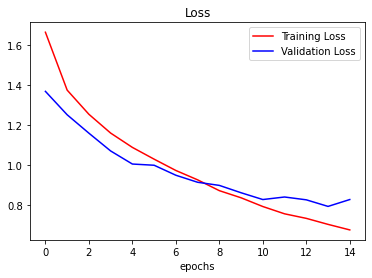

<Figure size 432x288 with 0 Axes>

In [8]:
def plot_trend_by_epoch(tr_values, val_values, title):
    epoch_number = range(len(tr_values))
    plt.plot(epoch_number, tr_values, 'r')
    plt.plot(epoch_number, val_values, 'b')
    plt.title(title)
    plt.xlabel('epochs')
    plt.legend(['Training '+title, 'Validation '+title])
    plt.figure()

hist_dict = history.history
tr_loss, val_loss = hist_dict['loss'], hist_dict['val_loss']
plot_trend_by_epoch(tr_loss, val_loss, "Loss")


**Plot accuracy**

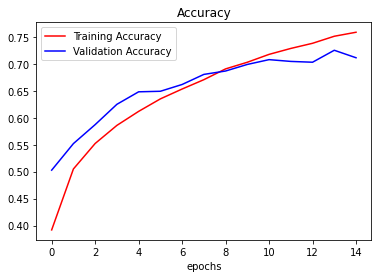

<Figure size 432x288 with 0 Axes>

In [9]:
tr_accuracy, val_accuracy = hist_dict['accuracy'], \
                            hist_dict['val_accuracy']
plot_trend_by_epoch(tr_accuracy, val_accuracy, "Accuracy")


**Plot confusion matrix with and without normalization.**

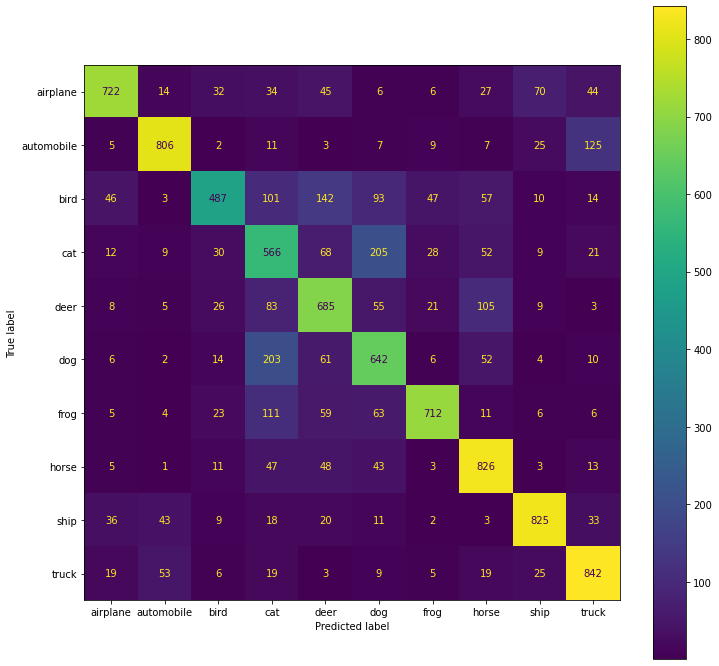

In [10]:
test_labels = []
test_images = []
for image, label in tfds.as_numpy(our_test_dataset.unbatch()):
    test_images.append(image)
    test_labels.append(label)
test_labels = np.array(test_labels)

predictions = our_classification_model.predict(our_test_dataset).argmax(axis=1)

conf_matrix = confusion_matrix(test_labels, predictions)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels = names_of_classes,)
fig = plt.figure(figsize = (12, 12))
axis = fig.add_subplot(111)
disp.plot(values_format = 'd', ax = axis)


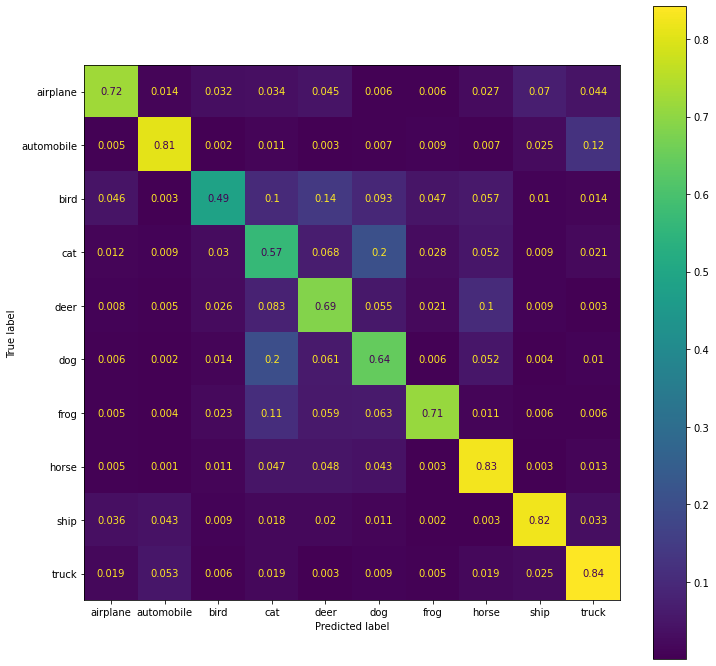

In [11]:
conf_matrix = conf_matrix.astype\
              ('float') / conf_matrix.sum(axis=1) \
              [:, np.newaxis]

disp = ConfusionMatrixDisplay(\
       conf_matrix, display_labels = names_of_classes)
fig = plt.figure(figsize = (12, 12))
axis = fig.add_subplot(111)
disp.plot(ax = axis)


**Check random incorrectly classified image.**

True label: dog
Predicted label: cat


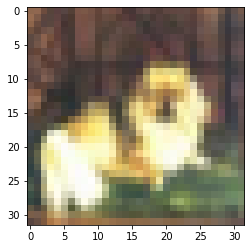

In [12]:
incorrect_predictions = np.where(predictions != test_labels)[0]
index = np.random.choice(incorrect_predictions)

plt.imshow(test_images[index])
print(f'True label: {names_of_classes[test_labels[index]]}')
print(f'Predicted label: {names_of_classes[predictions[index]]}')
